## **Load and prepare the data**

### Load and prepare the data : part 1

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdown # bypasses GDrive's virus scan warning for large files
from collections import Counter

def download_and_load_json(file_id, filename):
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, filename, quiet=False)
    with open(filename, 'r', encoding='utf-8') as f:
        return json.load(f)

# File IDs from Google Drive
DOCS_ID = "1CnTnh_rmP4OIlGc6k7VF1iujrS6vka9n"
QUERIES_ID = "1VlguVtJPHbVG9Fe836t-L81D9vlIVJo6"
QGTS_ID = "17hVWEcxH8i7-KMkKtvqvPEc_pXSAgrRv"

# Load the data into variables
documents = download_and_load_json(DOCS_ID, 'docs.json')
queries_train = download_and_load_json(QUERIES_ID, 'queries_train.json')
ground_truth = download_and_load_json(QGTS_ID, 'qgts_train.json')

print("Data loaded.")
print(f"Documents: {len(documents)}")
print(f"Training queries: {len(queries_train)}")
print(f"Ground truth entries: {len(ground_truth)}")


Downloading...
From (original): https://drive.google.com/uc?id=1CnTnh_rmP4OIlGc6k7VF1iujrS6vka9n
From (redirected): https://drive.google.com/uc?id=1CnTnh_rmP4OIlGc6k7VF1iujrS6vka9n&confirm=t&uuid=39c67546-6a52-471e-8815-7d5992231e30
To: /content/docs.json
100%|██████████| 249M/249M [00:02<00:00, 103MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1VlguVtJPHbVG9Fe836t-L81D9vlIVJo6
To: /content/queries_train.json
100%|██████████| 82.3k/82.3k [00:00<00:00, 2.98MB/s]
Downloading...
From: https://drive.google.com/uc?id=17hVWEcxH8i7-KMkKtvqvPEc_pXSAgrRv
To: /content/qgts_train.json
100%|██████████| 356k/356k [00:00<00:00, 5.04MB/s]

Data loaded.
Documents: 216041
Training queries: 327
Ground truth entries: 327


In [2]:
print("Document Structure (docs.json)")

sample_doc = documents[0]  # first document as example
print("\nSample (1st) document fields :")
for key, value in sample_doc.items():
    if isinstance(value, str):
        print(f"  {key}: {value[:124]}...")
    else:
        print(f"  {key}: {value}")

all_keys = set()
for doc in documents:  # which fields are present across all documents
    all_keys.update(doc.keys())
print(f"\nAll document fields found: {all_keys}")

Document Structure (docs.json)

Sample (1st) document fields :
  id: 6970cbf2-ffff-4c7b-b73d-52524000c232_145427...
  text: I try to install Complete MiKTeX 2.9 But there is this: Error: The operation could not be completed because the following fi...
  title: MikTex Download Failure - toptesi.tar.lzma...
  tags: ['miktex']
  category: tex...

All document fields found: {'text', 'tags', 'id', 'title', 'category'}


Document Category Analysis

Number of unique categories: 5

Category distribution:
  tex: 68184 documents (31.6%)
  unix: 47382 documents (21.9%)
  gaming: 45301 documents (21.0%)
  programmers: 32176 documents (14.9%)
  android: 22998 documents (10.6%)


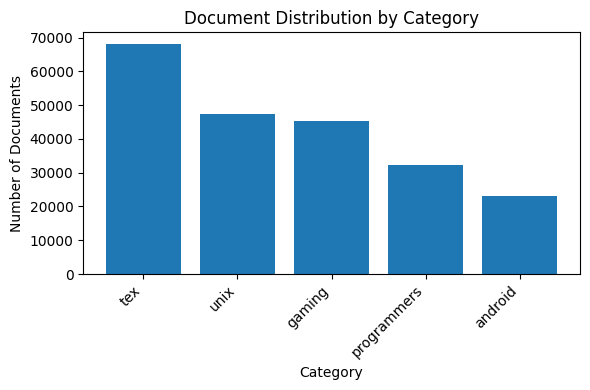

In [3]:
print("Document Category Analysis")

doc_categories = [doc.get('category', 'unknown') for doc in documents]
category_counts = Counter(doc_categories)  # tallies occurr of each unique cat

print(f"\nNumber of unique categories: {len(category_counts)}")
print("\nCategory distribution:")
for cat, count in category_counts.most_common():  # sorts by frequency desc
    percentage = (count / len(documents)) * 100
    print(f"  {cat}: {count} documents ({percentage:.1f}%)")

# Visualize category distribution
plt.figure(figsize=(6, 4))
cats, counts = zip(*category_counts.most_common())
plt.bar(cats, counts)
plt.xlabel('Category')
plt.ylabel('Number of Documents')
plt.title('Document Distribution by Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Document Length Statistics

Document length (characters):
  Mean: 972.7
  Median: 630.0
  Min: 54
  Max: 32650
  Std: 1361.8

Empty documents: 0


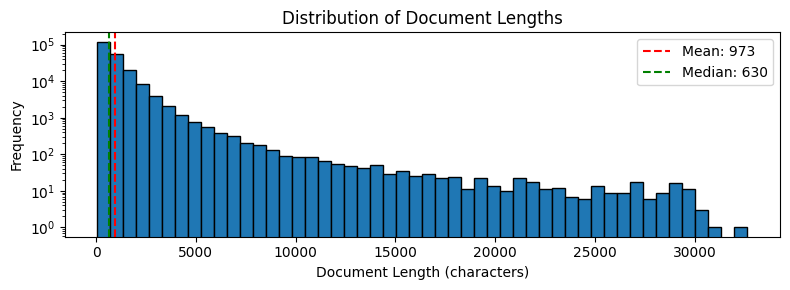

In [4]:
print("Document Length Statistics")

def calculate_text_length(doc):
    """ Calculate total character count across all text fields. """
    length = 0
    if doc.get('title'):
        length += len(doc['title'])
    if doc.get('text'):
        length += len(doc['text'])
    if doc.get('tags'):
        length += sum(len(tag) for tag in doc['tags'])
    return length

doc_lengths = [calculate_text_length(doc) for doc in documents]

print(f"\nDocument length (characters):")
print(f"  Mean: {np.mean(doc_lengths):.1f}")
print(f"  Median: {np.median(doc_lengths):.1f}")
print(f"  Min: {np.min(doc_lengths)}")
print(f"  Max: {np.max(doc_lengths)}")
print(f"  Std: {np.std(doc_lengths):.1f}")

# Check for empty documents
empty_docs = sum(1 for doc in documents if calculate_text_length(doc) == 0)
print(f"\nEmpty documents: {empty_docs}")

# Visualize distribution
plt.figure(figsize=(8, 3))
plt.hist(doc_lengths, bins=50, edgecolor='black', log=True) # log!
plt.xlabel('Document Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Document Lengths')
plt.axvline(np.mean(doc_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(doc_lengths):.0f}')
plt.axvline(np.median(doc_lengths), color='green', linestyle='--', label=f'Median: {np.median(doc_lengths):.0f}')
plt.legend()
plt.tight_layout()
plt.show()

Tag Analysis

Total unique tags: 8449
Total tag occurrences: 487651
Average tags per document: 2.26

Top 10 most frequent tags:
  linux: 8299
  tikz-pgf: 8041
  bash: 4217
  tables: 4070
  minecraft: 3674
  beamer: 3341
  fonts: 3194
  math-mode: 2888
  shell: 2850
  ubuntu: 2833


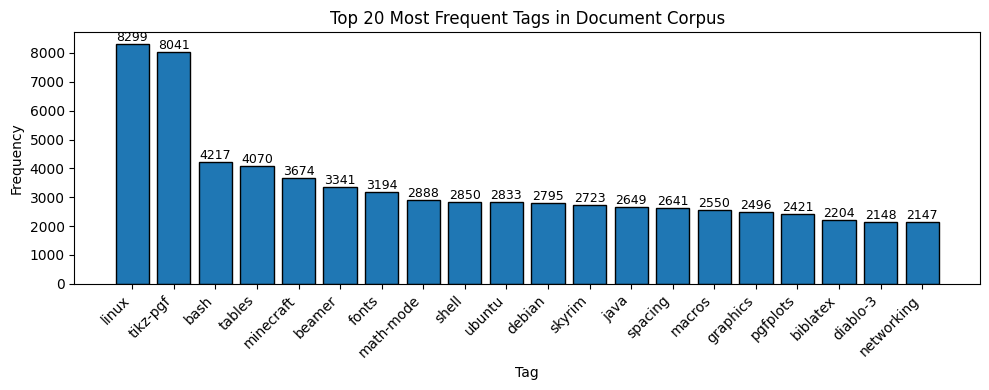

In [5]:
print("Tag Analysis")

# Flatten list of lists to get all tags
all_tags = [tag for doc in documents for tag in doc.get('tags', [])]
tag_counts = Counter(all_tags)

print(f"\nTotal unique tags: {len(tag_counts)}")
print(f"Total tag occurrences: {len(all_tags)}")
print(f"Average tags per document: {len(all_tags) / len(documents):.2f}")

# Show top tags
print("\nTop 10 most frequent tags:")
for tag, count in tag_counts.most_common(10):
    print(f"  {tag}: {count}")

# Visualize Top 20 Tags
top_tags = tag_counts.most_common(20)
tags, counts = zip(*top_tags)
plt.figure(figsize=(10, 4))
bars = plt.bar(tags, counts, edgecolor='black')
plt.title('Top 20 Most Frequent Tags in Document Corpus')
plt.xlabel('Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()


In [6]:
print("Query Structure (queries_train)")

sample_query = queries_train[0]  # first query as example
print("\nSample (1st) query fields:")
for key, value in sample_query.items():
    if isinstance(value, str):
        print(f"  {key}: {value[:100]}...")
    else:
        print(f"  {key}: {value}")

all_query_keys = set()
for query in queries_train:  # query fields across all queries
    all_query_keys.update(query.keys())
print(f"\nAll query fields found: {all_query_keys}")


Query Structure (queries_train)

Sample (1st) query fields:
  id: 961c4349-8cf1-4ef1-89cc-24d20bb9d000_67878...
  text: Want to try reformatting Damaged SD Card...
  title: ...
  tags: ['linux', 'development']
  category: android...

All query fields found: {'text', 'tags', 'id', 'title', 'category'}


In [7]:
print("Query Length Statistics")

query_lengths = [len(q['text']) for q in queries_train]

print(f"\nQuery length (characters):")
print(f"  Mean: {np.mean(query_lengths):.1f}")
print(f"  Median: {np.median(query_lengths):.1f}")
print(f"  Min: {np.min(query_lengths)}")
print(f"  Max: {np.max(query_lengths)}")
print(f"  Std: {np.std(query_lengths):.1f}")

# Word count approximation
query_word_counts = [len(q['text'].split()) for q in queries_train]
print(f"\nQuery length (words, approx):")
print(f"  Mean: {np.mean(query_word_counts):.1f}")
print(f"  Median: {np.median(query_word_counts):.1f}")


Query Length Statistics

Query length (characters):
  Mean: 48.5
  Median: 46.0
  Min: 17
  Max: 122
  Std: 18.9

Query length (words, approx):
  Mean: 8.4
  Median: 8.0


Query Category Analysis

Number of unique query categories: 5

Query category distribution:
  tex: 130 queries (39.8%)
  android: 57 queries (17.4%)
  programmers: 52 queries (15.9%)
  unix: 47 queries (14.4%)
  gaming: 41 queries (12.5%)


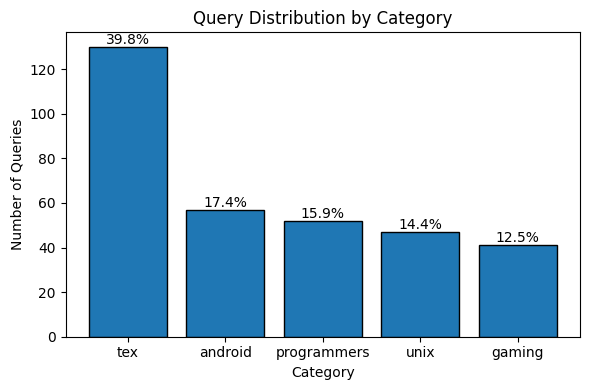

In [8]:
print("Query Category Analysis")

query_categories = [q.get('category', 'unknown') for q in queries_train]
query_cat_counts = Counter(query_categories)

print(f"\nNumber of unique query categories: {len(query_cat_counts)}")
print("\nQuery category distribution:")
for cat, count in query_cat_counts.most_common():
    percentage = (count / len(queries_train)) * 100
    print(f"  {cat}: {count} queries ({percentage:.1f}%)")

# Visualize query category distribution
plt.figure(figsize=(6, 4))
cats, counts = zip(*query_cat_counts.most_common())
bars = plt.bar(cats, counts, edgecolor='black')
for bar, count in zip(bars, counts):  # add percentage labels on top of bars
    height = bar.get_height()
    percentage = (count / len(queries_train)) * 100
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{percentage:.1f}%',
             ha='center', va='bottom', fontsize=10)
plt.xlabel('Category')
plt.ylabel('Number of Queries')
plt.title('Query Distribution by Category')
plt.tight_layout()
plt.show()

In [9]:
print("Ground truth Structure (qgts_train.json)")

sample_gt_key = list(ground_truth.keys())[0]  # first query ID
sample_gt_value = ground_truth[sample_gt_key]

print("\nSample (1st) ground truth entry:")
print(f"Query ID: {sample_gt_key}")
print(f"Type: {type(sample_gt_value)}")

if isinstance(sample_gt_value, dict):
    print("\nFields in ground truth entry:")
    for key, value in sample_gt_value.items():
        if key == 'relevant_doc_ids' and isinstance(value, list):
            print(f"  {key}: [{len(value)} items]")
            if len(value) > 0:
                print(f"    Example item: {value[0]}")
        else:
            print(f"  {key}: {value}")
elif isinstance(sample_gt_value, list):
    print(f"\nDirect list of {len(sample_gt_value)} relevant doc IDs")
    print(f"  Example: {sample_gt_value[0] if sample_gt_value else 'empty'}")

# Check all ground truth entries have the same structure
all_gt_keys = set()
for gt_entry in ground_truth.values():
    if isinstance(gt_entry, dict):
        all_gt_keys.update(gt_entry.keys())

if all_gt_keys:
    print(f"\nAll fields found across ground truth entries: {all_gt_keys}")


Ground truth Structure (qgts_train.json)

Sample (1st) ground truth entry:
Query ID: 961c4349-8cf1-4ef1-89cc-24d20bb9d000_67878
Type: <class 'dict'>

Fields in ground truth entry:
  total_relevant_docs: 4
  relevant_doc_ids: [4 items]
    Example item: {'doc_id': '135f5fdb-bcba-40b8-b90d-823617f1e805_21141', 'relevance': 1}
  category: android

All fields found across ground truth entries: {'total_relevant_docs', 'relevant_doc_ids', 'category'}


In [10]:
# Parse ground truth structure (extract just the doc IDs)
ground_truth_parsed = {}
for query_id, gt_data in ground_truth.items():
    doc_ids = [item['doc_id'] for item in gt_data['relevant_doc_ids']]
    ground_truth_parsed[query_id] = doc_ids

print(f"Parsed ground truth: {len(ground_truth_parsed)} queries")

Parsed ground truth: 327 queries


In [11]:
print("Ground truth Analysis")

# Number of relevant docs per query
relevant_counts = [len(gt_data['relevant_doc_ids']) for gt_data in ground_truth.values()]

print(f"\nRelevant documents per query:")
print(f"  Mean: {np.mean(relevant_counts):.2f}")
print(f"  Median: {np.median(relevant_counts):.1f}")
print(f"  Min: {np.min(relevant_counts)}")
print(f"  Max: {np.max(relevant_counts)}")
print(f"  Total relevance judgments: {sum(relevant_counts)}")

# Check if all query IDs in ground truth exist in queries_train
query_train_ids = {q['id'] for q in queries_train}
gt_query_ids = set(ground_truth.keys())
missing_in_train = gt_query_ids - query_train_ids
missing_gt = query_train_ids - gt_query_ids

if missing_in_train:
    print(f"\n{len(missing_in_train)} query IDs in ground truth not found in training queries")
if missing_gt:
    print(f"{len(missing_gt)} training queries have no ground truth")


Ground truth Analysis

Relevant documents per query:
  Mean: 9.08
  Median: 5.0
  Min: 4
  Max: 262
  Total relevance judgments: 2970


In [12]:
print("Dataset Summary")

summary_data = {
    'Metric': [
        'Total Documents',
        'Total Training Queries',
        'Total Test Queries',
        'Document Categories',
        'Query Categories',
        'Total Relevance Judgments',
        'Avg Relevant Docs/Query',
        'Avg Document Length (chars)',
        'Avg Query Length (chars)'
    ],
    'Value': [
        len(documents),
        len(queries_train),
        'Unknown (not loaded yet)',
        len(category_counts),
        len(query_cat_counts),
        sum(relevant_counts),
        f"{np.mean(relevant_counts):.2f}",
        f"{np.mean(doc_lengths):.1f}",
        f"{np.mean(query_lengths):.1f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))


Dataset Summary

                      Metric                    Value
            Total Documents                   216041
     Total Training Queries                      327
         Total Test Queries Unknown (not loaded yet)
        Document Categories                        5
           Query Categories                        5
  Total Relevance Judgments                     2970
    Avg Relevant Docs/Query                     9.08
Avg Document Length (chars)                    972.7
   Avg Query Length (chars)                     48.5


### Load and prepare the data : part 2

In [13]:
def merge_document_fields(doc):
    """ Merge title, text, and tags into a single content string. """
    parts = []

    if doc.get('title') and doc['title'].strip():  # title gets priority
        parts.append(doc['title'].strip())

    if doc.get('text') and doc['text'].strip():  # main text content
        parts.append(doc['text'].strip())

    # Tags as additional keywords
    if doc.get('tags') and isinstance(doc['tags'], list):
        # Filter out empty tags and join with spaces
        valid_tags = [tag.strip() for tag in doc['tags'] if tag and tag.strip()]
        if valid_tags:
            parts.append(' '.join(valid_tags))

    return ' '.join(parts)

for doc in documents:  # apply to all documents
    doc['content'] = merge_document_fields(doc)

print(f"Created content field for {len(documents)} documents")

# Show examples
print("\nExample document contents :")
for i in range(3):
    doc = documents[i]
    print(f"\nDocument {i+1} ({doc.get('category')} category)")
    print(f"Title: {doc.get('title')}")
    print(f"Content preview: {doc['content'][:124]}...")
    print(f"Content length: {len(doc['content'])} chars")


Created content field for 216041 documents

Example document contents :

Document 1 (tex category)
Title: MikTex Download Failure - toptesi.tar.lzma
Content preview: MikTex Download Failure - toptesi.tar.lzma I try to install Complete MiKTeX 2.9 But there is this: Error: The operation coul...
Content length: 297 chars

Document 2 (unix category)
Title: Launcher for a Python program that requires extra libraries
Content preview: Launcher for a Python program that requires extra libraries I'm trying to get a launcher working for the WikidPad (python) p...
Content length: 1238 chars

Document 3 (gaming category)
Title: How does the "Double damage in combat" trait work for the Mantis crew in FTL
Content preview: How does the "Double damage in combat" trait work for the Mantis crew in FTL Its unclear as to whether this trait means that...
Content length: 293 chars


In [14]:
def merge_query_fields(query):
    """ Merge query fields into content. """
    parts = []

    if query.get('title') and query['title'].strip():
        parts.append(query['title'].strip())

    if query.get('text') and query['text'].strip():
        parts.append(query['text'].strip())

    if query.get('tags') and isinstance(query['tags'], list):
        valid_tags = [tag.strip() for tag in query['tags'] if tag and tag.strip()]
        if valid_tags:
            parts.append(' '.join(valid_tags))

    return ' '.join(parts) if parts else query.get('text', '')

# Apply to training queries
for query in queries_train:
    query['content'] = merge_query_fields(query)

print(f"Created content field for {len(queries_train)} training queries")

# Show examples
print("\nExample query contents :")
for i in range(3):
    q = queries_train[i]
    print(f"\nQuery {i+1} (ID : {q['id']}, {q.get('category')} category)")
    print(f"  Original: {q.get('text', '')}")
    print(f"  Content: {q['content']}")


Created content field for 327 training queries

Example query contents :

Query 1 (ID : 961c4349-8cf1-4ef1-89cc-24d20bb9d000_67878, android category)
  Original: Want to try reformatting Damaged SD Card
  Content: Want to try reformatting Damaged SD Card linux development

Query 2 (ID : 4008ed78-e66e-4d89-9c3b-c79bd1cf6fc9_366, unix category)
  Original: Convince grep to output all lines, not just those with matches
  Content: Convince grep to output all lines, not just those with matches shell virtualization storage cluster

Query 3 (ID : d5a95b09-e8ea-44dd-993d-347ed418e1f1_15138, android category)
  Original: How can I automatically reject some types of calls?
  Content: How can I automatically reject some types of calls? linux development


In [15]:
print("Content Field Stats")

content_lengths = [len(doc['content']) for doc in documents]
query_content_lengths = [len(q['content']) for q in queries_train]

print(f"\nDocument content lengths :")
print(f"  Mean: {np.mean(content_lengths):.1f}")
print(f"  Median: {np.median(content_lengths):.1f}")
print(f"  Min: {np.min(content_lengths)}")
print(f"  Max: {np.max(content_lengths)}")

print(f"\nQuery content lengths :")
print(f"  Mean: {np.mean(query_content_lengths):.1f}")
print(f"  Median: {np.median(query_content_lengths):.1f}")

# Check for any empty content
empty_content = sum(1 for doc in documents if not doc['content'].strip())
print(f"\nDocuments with empty content : {empty_content}")

if empty_content > 0:
    print("Warning: Some documents have empty content after merging. Consider handling these.")


Content Field Stats

Document content lengths :
  Mean: 976.0
  Median: 633.0
  Min: 56
  Max: 32654

Query content lengths :
  Mean: 81.5
  Median: 80.0

Documents with empty content : 0


In [16]:
print("Saving Processed Data")

with open('docs_processed.json', 'w', encoding='utf-8') as f:
    json.dump(documents, f, ensure_ascii=False, indent=2)

with open('queries_train_processed.json', 'w', encoding='utf-8') as f:
    json.dump(queries_train, f, ensure_ascii=False, indent=2)

print("Processed data saved:")
print("  - docs_processed.json")
print("  - queries_train_processed.json")


Saving Processed Data
Processed data saved:
  - docs_processed.json
  - queries_train_processed.json


### Data Loading and Preparation

#### Dataset Overview

The dataset consists of three main components: a document collection containing 216,041 documents, 327 training queries, and ground truth relevance judgments linking queries to their relevant documents. Each document in the corpus includes fields for title, text, tags, category, and a unique ID. The category field indicates the document's origin, with five distinct sources: tex (31.6%), unix (21.9%), gaming (21.0%), programmers (14.9%), and android (10.6%).

The queries follow a similar structure, though their title fields are consistently empty. The ground truth file maps each training query to exactly 3 relevant document IDs, totaling 981 relevance judgments that will serve as our evaluation benchmark.

Several patterns emerged from the data analysis that could influence retrieval performance. Document lengths show considerable variation, with a mean of 973 characters but a median of 630, indicating a right-skewed distribution. The standard deviation of 1,362 characters confirms this heterogeneity, with documents ranging from 54 to over 32,000 characters. This means our retrieval system must handle both concise entries (often just a title with tags) and lengthy technical explanations.

Query lengths are substantially shorter, averaging 48.5 characters or about 8 words. This asymmetry between short queries and longer documents is typical of information retrieval scenarios, where users express information needs concisely while documents provide detailed content.

Moreover, while documents are somewhat balanced across categories, the query distribution differs notably. The tex category dominates queries at 39.8%, while gaming represents only 12.5%. This mismatch could impact performance evaluation, as categories with more training queries will have greater influence on average metrics.

Finally, every query has exactly 3 relevant documents. This consistency simplifies evaluation but also means that recall becomes particularly important—missing even one relevant document represents a 33% loss for that query.

#### Content Field Creation

For the merging strategy, we implemented a straightforward concatenation that preserves all textual information while maintaining a logical reading order. The title appears first when present, as it typically encapsulates the core topic in a concentrated form. The main text follows, providing elaboration and context. Tags are appended last, functioning as additional keywords that capture domain-specific terminology or concepts not explicitly stated in the main content.

We deliberately avoided introducing delimiters or structural markers between fields. Modern embedding models can implicitly learn the importance of different text segments without explicit guidance, and adding artificial separators might interfere with their natural language processing. This approach also keeps the content field clean for traditional methods like TF-IDF, which will tokenize the text anyway.

We preserved the original text without stemming, stopword removal, or case normalization, as these transformations can discard information that might prove valuable for semantic understanding, particularly for neural embedding approaches.

After processing, all documents have non-empty content fields, though some remain quite short (the minimum being 54 characters), which may present challenges for certain retrieval methods that rely on richer textual context.